# FETHCHING IMF TIME SERIES DATA WITH PYTHON - A SYNCHRONOUS VS AN ASYNCHRONOUS APPROACH

<i>Daniel Tiwonge Mhango</i>

<h4><b>INTRODUCTION</b></h4>

Having worked on several projects requiring the analysis of macroeconomic data for various countries/regions and with several more lined up, it dawned on me that this is something that should be easy to automate with python.

The first step of any analysis is obtaining the data in the desired format. There are several free sources of macroeconomic data including the IMF, The World Bank and FRED (Federal Reserve Economic Data). I chose to retrive data from the IMF. The IMF provides a few different API's for accessing their various databases including the <a href= 'https://www.imf.org/external/datamapper/api/help'>DataMapper API</a> and the <a href = 'https://datahelp.imf.org/knowledgebase/articles/630877-api'>JSON RESTful Web Service</a>.

The DataMapper makes use of data from the World Economic Outlook database which is the most ideal for my use case. The JSON RESTful Web Service gives more flexibility on the database to reference, allowing you to decide on the specific [dataset(s)](https://data.imf.org/?sk=388DFA60-1D26-4ADE-B505-A05A558D9A42&sId=1479329132316) that suits your needs. I must emphasize that this write-up is not suggesting the best way to obtain data from the IMF database for every single use case. More likely than not, your use case will differ from mine and the format you require the data in may also differ. Rather, the goal of this is to outline some simple code that makes use of the IMF's database to automate data collection and preprocessing. Modifications to the code for different use cases should be fairly straightforward from what will be discussed.

<b>Let's begin by importing some typical libraries</b>


In [1]:
import pandas as pd
import requests
import time

<code>requests</code> for our API calls, <code>pandas</code> for the data preprocessing and <code>time</code> to check our run time. For this example case we will fetch time series data from 2000 to the last projected date for each macroeconomic indicator for Zambia. WEO typically provides 5 year projections so the time series will be annual data from 2000 to 2028. Note that not all indicators will have projected values and some will not even have data as early as 2000. If you require quarterly or monthly data then you should make use of the JSON RESTful Web Service and a different database. The IMF does state that for such granularity, data availability is dependent on the in-country reports that are available and how often data is gathered within the specific country - annual reports are far more common than their quarterly or monthly counterparts.

Let's set our <code>BASE_API_URL</code> and <code>COUNTRY</code> as constants.


In [2]:
BASE_API_URL = 'https://www.imf.org/external/datamapper/api/v1/'
COUNTRY = 'Zambia'

The DataMapper <a href = 'https://www.imf.org/external/datamapper/api/help'>API Documentation</a> outlines the structure of configuring the API endpoint for your request. This must include at least one indicator ID and zero or more countries - zero countries will retrieve the time series data of that indicator for all countries and regions. This will look something like this for our example `https://www.imf.org/external/datamapper/api/v1/{indicator_code}/{country_code}?periods=date_range`. The indicator ID and country can be added in any order and can take multiple values at a time. For example:

`https://www.imf.org/external/datamapper/api/v1/{indicator_1}/{indicator_2}/{country_1}/{country_2}?periods={date_range}`

and

`https://www.imf.org/external/datamapper/api/v1/{country_2}/{indicator_1}/{indicator_2}/{country_1}?periods={date_range}`

will both return the exact same result. While you can request the time series for all countries for a given indicator, the documentation does not provide an endpoint for requesting all indicators for a given country. Additionally, you would need to know the indicator ID(s) beforehand to configure your API endpoint. You would also need to know the <a href = 'https://www.iban.com/country-codes'>ISO 3166-1 alpha-3</a> code for the country/countries as this is what the API requires. (_Side note: the JSON RESTful Web Service uses ISO 3166-1 alpha-2 country codes in it's endpoint configuration_).

Luckily, the IMF provides endpoints to reference the available indicators and country codes the data is mapped to. The codes are updated at the discretion of the IMF so memorizing or statically storing specific codes may not be a good approach regardless of how rarely updates may actually occur in practice. Let's take a look at the responses from our API calls and define some functions to retrieve the available country codes and indicator IDs in a suitable format.


In [51]:
response = (requests.get(f"{BASE_API_URL}indicators")) 
# good debugging practice is to check the response code by using .raise_for_status() from the requests library
data = (response.json())
# data

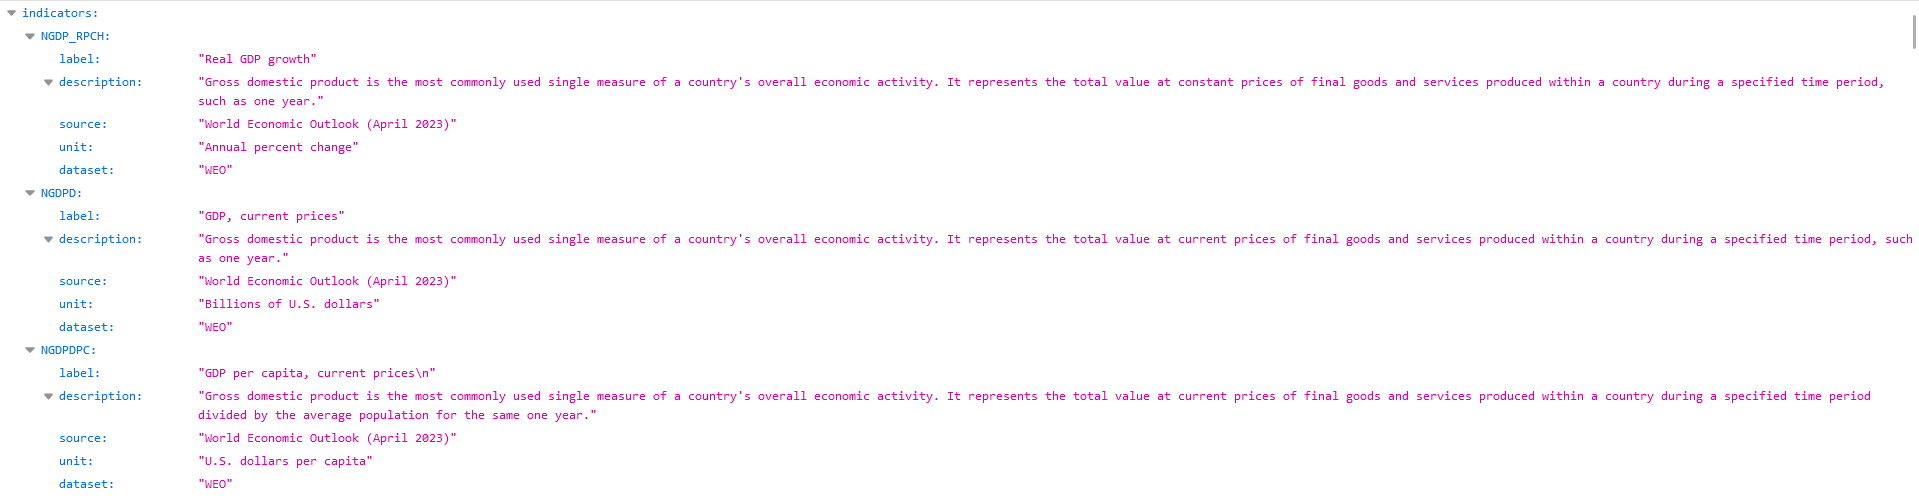

The above returns a JSON file where each indicator ID is the key and the values are a nested dictionary with the following <code>key: value</code> pairs:

- label:&nbsp; &nbsp; &nbsp; &nbsp;_The name of the indicator_
- description:&nbsp; &nbsp; &nbsp; &nbsp;_A description of what the indicator represents_
- source:&nbsp; &nbsp; &nbsp; &nbsp;_The IMF publication the data references_
- unit:&nbsp; &nbsp; &nbsp; &nbsp;_The unit of measurement e.g. Billions of USD_
- dataset:&nbsp; &nbsp; &nbsp; &nbsp;_The database the data was retrieved from_

Minor notes:

- I will use <code>indicator_code</code> and <code>code</code> for variable names rather than <code>indicator_id</code> and <code>id</code> to avoid confusion with the <code>id()</code> method.
- Rather than displaying the code output directly which would clutter the notebook when exported, I have opted to open the JSON files in Firefox and used the JSON viewer to present the tidier images of the API call responses.

Let's now define our function.


In [24]:
def get_indicator_codes(): 
    """returns dictionary with indicator codes as keys and indicator 'label + units' as values"""
    response = requests.get(f"{BASE_API_URL}indicators")
    data = (response.json())['indicators']
    indicator_codes = {code: f"{data[code]['label']} - {data[code]['unit']}" for code in data.keys()}
    return indicator_codes

indicator_codes = get_indicator_codes()

<img src = ' 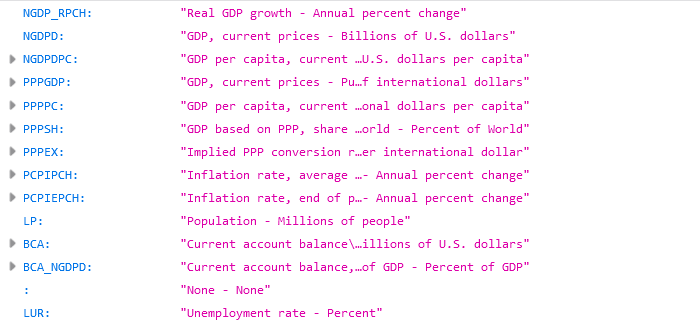' alt = 'Dictionary'>

This returns a dictionary with the indicator codes as keys and the label concatenated with the units as the values. The concatenation of the units is important for later. Also, take note of the <code>'': 'None - None'</code> key: value pair. Next let's look at the available countries/regions/groups.


In [25]:
collections = ['countries', 'regions', 'groups'] # available groupings

responses = [(requests.get(f"{BASE_API_URL}{collection}")).json()[collection] for collection in collections]

<img src = ' 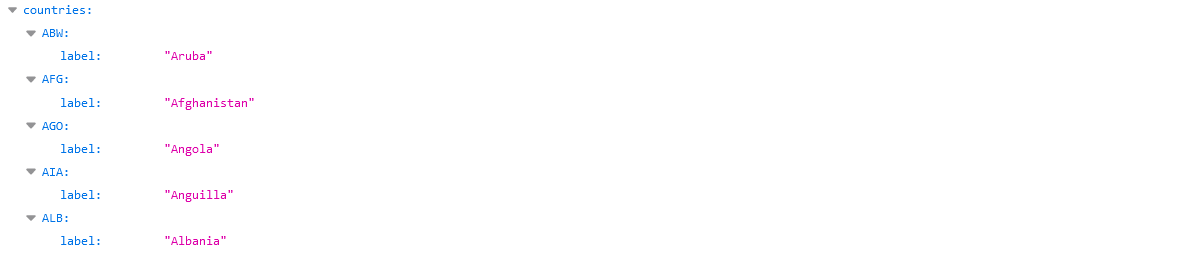' alt = 'Countries'>

_Countries_

For each of the items in our list we get a different JSON file that details the available codes and labels. As previously mentioned we will focus on countries and use Zambia as our example however, almost everything related to configuring the API endpoints is applicable for regions and groups.

<img src = ' 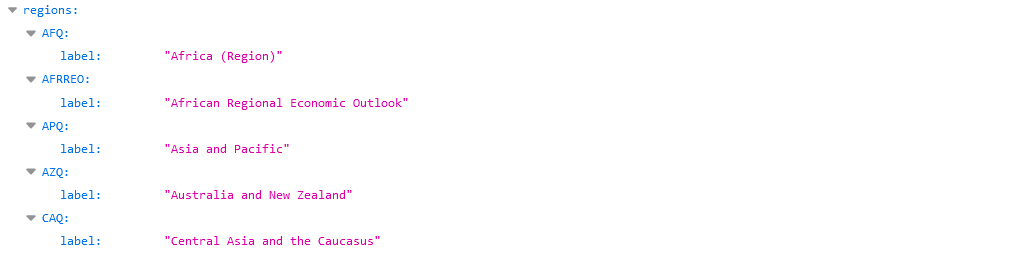' alt = 'Regions'>

_Regions_

<img src = ' 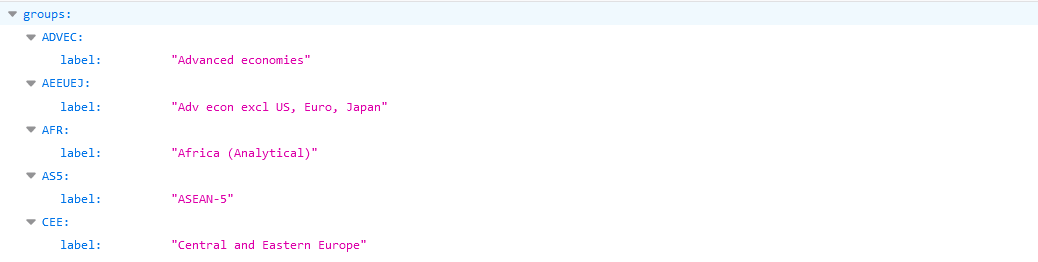' alt = 'Groups'>

_Groups_

We now extract the relevant country code.


In [26]:
def get_country_code(country):
    """returns the country code of the country provided"""
    country = country.casefold()
    response = requests.get(f"{BASE_API_URL}countries")
    data = (response.json())["countries"]
    # create a key: value pair with the country name as the key and alpha-3 code as the value
    country_codes = {str(data[code]['label']).casefold(): code for code in data}
    code = country_codes[country]
    return code

country_code = get_country_code(COUNTRY)
print(country_code)
print(get_country_code('zAmBiA'))

ZMB
ZMB


Generally speaking, one is more likely to know the country name but not it's ISO 3166 alpha-3 code. This function simply looks up the country name and returns the alpha-3 code per the IMF's database. Alternatively, if you are aware of the country code you can bypass the need for this function entirely. Skipping this could potentially be helpful if the country has gone through a name change but the alpha-3 code has remained the same e.g., Eswatini maintains the SWZ code. The <code>casefold()</code> method is simply there to avoid a <code>KeyError</code> due to incorrect casing i.e., zambia instead of Zambia or other case variations. As demonstrated above, <code>zAmBiA</code> still returns the correct country code. I have not tackled spelling mistakes so there is a need to ensure the correct spelling is used.

The last part of our API endpoint configuration deals with the period(s) of data that we want to retrieve. As previously mentioned, we will be requesting data from 2000 to 2028. However, data for certain periods may not be available and in such cases the API will simply not return anything for those periods - and luckily will not return a 404 error.


In [11]:
def api_date_range(start=2000, end=2030):
    date_range = ",".join(map(str, range(start, end)))
    return f'?periods={date_range}'

date_range = api_date_range()
print(date_range)

?periods=2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029


Requesting data for specific period requires the periods to be provided as above. The default values have been set as my usage for this data typically involves the years 2000 to date and any projections thereafter. For the WEO database the earliest start date is 1980 for many of the indicators however, to reiterate, setting your start date to 1920 and your end date to 2050 for example, will not result in an error.


In [28]:
response = (requests.get(url= f'{BASE_API_URL}ZMB/NGDP_RPCH/{api_date_range(1920, 2050)}'))
data = response.json()

<img src =' 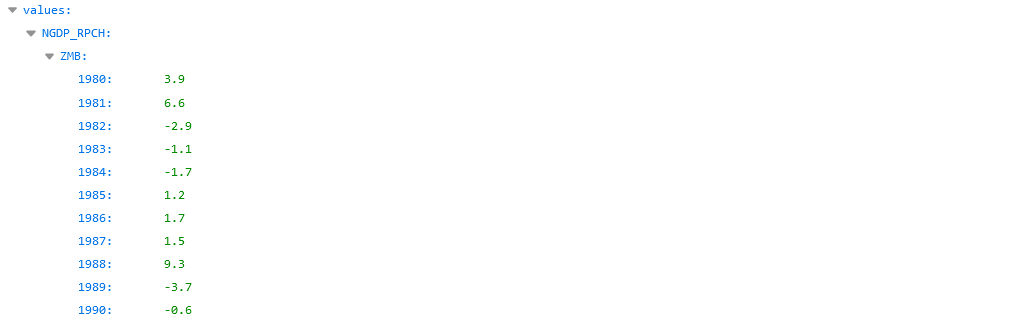' alt = 'SampleData'>

The extract above shows that although we have requested data in the range 1920 - 2050, we get back only what is available from that range i.e., 1980 to 2028 _(image cropped to save space)_

We can now define a function to retrieve the indicator time series data.


In [29]:
def get_data(country_code, indicator_codes, indicator_code, date_range):
    """Returns a dataframe with data for a single indicator based on the indicator code, country, and date range.
    The column name is obtained by checking the indicator_codes dictionary for the indicator code."""
    response = (requests.get(url= f'{BASE_API_URL}{country_code}/{indicator_code}/{date_range}'))
    data = response.json()
    indicator_df = pd.DataFrame(data['values'][indicator_code])
    indicator_df.columns = [indicator_codes[indicator_code]]
    return indicator_df

The funtion returns a dataframe with the <code>indicator name + unit</code> as the column name


In [30]:
df = get_data('ZMB', indicator_codes, 'NGDP_RPCH', api_date_range())
df.head()

,Real GDP growth - Annual percent change
2000,3.9
2001,5.3
2002,4.5
2003,6.9
2004,7.0


Let us now retrieve the data for all the indicators available for Zambia. Note the indicator codes as per the IMFs databases contain some blank values - remember the <code>'': 'None - None'</code> key-value pair from the indicator dictionary above? These will return empty JSON files and result in a <code>KeyError</code> when attempting to access the non-existent <code>['values']</code> key. Hence the <code>try/except</code> block to handle these.


In [42]:
start = time.time()

macro_data_list = []

for code in list(indicator_codes.keys()):
    try:
        df = get_data(country_code, indicator_codes, code, date_range)
        macro_data_list.append(df)
    except KeyError:
        pass

macro_data = pd.concat(macro_data_list, axis = 1)
end = time.time() - start
print(f'This took {end} seconds')

This took 286.27250266075134 seconds


Excellent, we have achieved our goal and it only took...286 seconds. Ok, not excellent - barely decent even. This was one of the fastest runs out of all my testing. On average the process took about 340s (5-6 mins) to complete. In all honesty, this is still faster than going to the IMF website, downloading the relevant data to csv or excel and manually preparing it for analysis but there has to be a better way, right?

Let's view our final dataframe.


In [32]:
macro_data.head()

,Real GDP growth - Annual percent change,"GDP, current prices - Billions of U.S. dollars","GDP per capita, current prices\n - U.S. dollars per capita","GDP, current prices - Purchasing power parity; billions of international dollars","GDP per capita, current prices - Purchasing power parity; international dollars per capita","GDP based on PPP, share of world - Percent of World",Implied PPP conversion rate - National currency per international dollar,"Inflation rate, average consumer prices - Annual percent change","Inflation rate, end of period consumer prices - Annual percent change",Population - Millions of people,...,Imports of Goods and Services (% of GDP) - Percent of GDP,Trade Balance (% of GDP) - Percent of GDP,Net Foreign Direct Investment (% of GDP) - Percent of GDP,Reserves (Months of Imports) - Months of imports of goods and services,"Real Effective Exchange Rates (2010=100) - Annual Average Index, 2010 = 100","Nominal Effective Exchange Rates (2010=100) - Annual Average Index, 2010 = 100","External Debt, Official Debt, Debtor Based (% of GDP) - Percent of GDP","Consumer Prices, Average (Annual % Change) - Annual average percent change","Consumer Prices, End of Period (Annual % Change) - Annual average percent change","Terms of Trade (Index, 2010 = 100) - Index, 2010 = 100"
2000,3.9,3.601,364.026,17.114,1730.226,0.034,0.654,24.1,30.1,9.891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,5.3,3.870,379.713,18.430,1808.276,0.035,0.802,21.4,18.7,10.192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,4.5,4.194,399.099,19.561,1861.437,0.035,0.943,22.2,26.7,10.508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,6.9,4.902,452.287,21.332,1968.253,0.036,1.088,21.4,17.2,10.838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,7.0,6.221,556.050,23.445,2095.534,0.037,1.268,18.0,17.5,11.188,...,34.711431,2.322155,5.852654,1.035445,65.133517,99.819752,110.827494,17.968588,17.502406,58.31334


The dataframe contains 101 indicator columns and 29 rows of data - for the years 2000 to 2028 and as required. The only problem is that it's too slow.

The challenge with the code above is that for each subsequent indicator a new request is made only after a response to our current request is returned. In other words, the request currently being made blocks the next request from executing until a response is returned. Most of the countries whose data I need have over 100 indicators - the maximum number of available indicators in WEO is 128. It takes about 2 to 5 seconds to get a response with fairly decent internet speed. This tranlsates to 250 - 650 seconds for the code to finish execution depending on the country data requested, internet speed and other typical factors affecting API response time.

Chaining multiple indicators when configuring the API endpoint would decrease the overall execution time however, this works only up to a point. The maximum numbers of indicators that can be chained together in a single request is 24. This is not documented by the IMF and I had to learn this through trial and error. Although the execution time did drop to about 45 seconds, the frustration of trying to manually minimize execution time this way led me to looking at other possible solutions. Enter Asynchronous API requests.

Asynchronous code is designed to help bypass blocking behaviour by scheduling tasks and allowing them to be executed independently without waiting for a previous task to complete. In python, this can be done by using the <a href = 'https://docs.python.org/3/library/asyncio.html'>Asyncio</a> library. <a href = 'https://www.youtube.com/watch?v=t5Bo1Je9EmE'>This video by Tim Ruscica</a> provides a nice introduction to the asyncio library, async/await syntax and awaitables.

This is a good time to mention that the DataMapper API does not have any documented rate limitations for the number of requests a user can make. The JSON RESTful Web Service on the other hand has a <a href = 'https://datahelp.imf.org/knowledgebase/articles/630877-data-services#:~:text=Also%2C%20please%20be%20aware%20of,second%20overall%20on%20the%20application'>documented limit</a> of _"10 requests in 5 second window from one user (IP); 50 requests per second overall on the application"_. Keep this in mind if you need to use it.

Let's now import Asyncio and a few other libraries to help with solving our challenge.


In [4]:
import asyncio
import nest_asyncio
import aiohttp
import re

<a href = 'https://docs.aiohttp.org/en/stable/'>Aiohttp</a> is a library for making asynchronous API requests with asyncio, the <a href = 'https://pypi.org/project/nest-asyncio/'>nest_asyncio</a> module allows us to nest the asyncio event loop - more on this later - and `re` for regular expressions.

Let's define asynchronous versions of our previous functions


In [5]:
async def get_country_code_async(session, country):
    country = country.casefold()
    async with session.get(f"{BASE_API_URL}countries") as response:
        data = (await response.json())["countries"]
        country_codes = {str(data[code]['label']).casefold(): code for code in data}
        code = country_codes[country]
        return code

This is similar to the synchronous version but we note the following changes

- <code>async def</code> is used to define asynchronous funtions,
- <code>async with</code> is used to create asynchronous context managers and
- <code>await</code> is used to yield execution to another <a href = 'https://docs.python.org/3/library/asyncio-task.html#coroutines'>coroutine</a> or <a href = 'https://docs.python.org/3/library/asyncio-task.html#awaitables'>awaitable</a>

We will create our `session()` in a separate funtion below. Unlike with <code>requests</code>, the <a href = 'https://docs.aiohttp.org/en/stable/client_quickstart.html'>aiohttp documentation</a> advises that you do not create a session per request. Let's move on to the asynchronous versions of the next two functions.


In [6]:
async def get_all_indicators_async(session):
    async with session.get(f"{BASE_API_URL}indicators") as response:
        data = (await response.json())['indicators']
        indicator_codes = {code: f"{data[code]['label']} - {data[code]['unit']}" for code in data.keys()}
        return indicator_codes
    
async def fetch_indicator_data(session, indicator_dict, code, country_code, date_range):
    try:
        async with session.get(f"{BASE_API_URL}{country_code}/{code}/{date_range}") as response:
            data = await response.json()
            indicator_df = pd.DataFrame(data['values'][code])
            indicator_df.columns = [indicator_dict[code]]
            return indicator_df
    except KeyError:
        return None

These two funtions return <a href = 'https://docs.python.org/3/c-api/coro.html'>coroutine objects</a> which will return the indicator codes dictionary and a dataframe for a single indicator once they have been awaited.

We now define a funtion to fetch the data for all the indicators in our indicator_codes dictionary and return a concatenated dataframe of the indicators.


In [7]:
async def fetch_all_indicator_data(session, indicator_dict, country_code, date_range):
    indicators = [item for item in indicator_dict.keys() if item != '']
    tasks = [fetch_indicator_data(session, indicator_dict, code, country_code, date_range) for code in indicators]
    results = await asyncio.gather(*tasks)
    df_list = [result for result in results if result is not None]
    return pd.concat(df_list, axis = 1)

<a href = 'https://docs.python.org/3/library/asyncio-task.html#creating-tasks'>Tasks</a> are another type of awaitable in asyncio. They are objects that schedule and independently run an asyncio coroutine. We can create a task by passing a coroutine to `asyncio.create_task()`. To learn more about the advantages of tasks, when to create them and why they should be preferred over running the coroutine directly see <a href = 'https://superfastpython.com/asyncio-task/'>this post by Jason Brownlee, Ph.D.</a>. In the code above we could schedule each of the coroutines returned by `fetch_indicator_data()` as a task by setting:

<code>tasks = [asyncio.create_task(fetch_indicator_data(session, indicator_dict, code, country_code, date_range)) for code in indicators]</code>

However, <code>asyncio.gather(\*tasks)</code> automatically schedules any awaitables passed to it as tasks. If all awaitables are completed successfully, the result is an aggregate list of returned values.

Lastly, we filter out any <code>None</code> objects that result from some of the blank keys in the IMF database as previously mentioned. This to avoid errors in <code>pd.concat()</code>.

Let's now define our main function.


In [8]:
async def main():
    async with aiohttp.ClientSession() as session:
        country_code = await get_country_code_async(session, COUNTRY)
        indicator_dict = await get_all_indicators_async(session)
        data = await fetch_all_indicator_data(session, indicator_dict, country_code, api_date_range())
        return data

We create an instance of the class <code>aiohttp.ClientSession()</code> to use as the interface for making our requests and the <a href = 'https://superfastpython.com/asyncio-async-with/#What_is_an_Asynchronous_Context_Manager'>asynchronous context manager</a> - <code>async with</code> - to set it as <code>session</code>. The <code>ClientSession()</code> class supports the context manager protocol for self-closing and without this we would need to close the session manually using the <code>close()</code> method. Finally, we call <code>asyncio.run()</code> and pass <code>main()</code> to it. This function is used to run the passed coroutine and manage the <a href = 'https://docs.python.org/3/library/asyncio-eventloop.html'>asyncio event loop</a>. However, we may need to incorporate a single line of code to make sure this works in our Jupyter notebook - <code>nest_asyncio.apply()</code>.


In [9]:
nest_asyncio.apply()

<a href = 'https://pypi.org/project/nest-asyncio/'>nest_asyncio</a> is used to patch the asyncio event loop. From the project description: "When in an environment where the event loop is already running it’s impossible to run tasks and wait for the result. Trying to do so will give the error <code>RuntimeError: This event loop is already running</code>."

Since jupyter notebooks have a running event loop to handle asynchronous operations, it is possible to run into this error hence we use <code>nest_asyncio.apply()</code> to avoid it.

Now to get our data!


In [21]:
start = time.time()

macro_data_2 = asyncio.run(main())

end = time.time() - start
print(f'This took {end} seconds.')
macro_data_2.head()

This took 21.523168802261353 seconds.


,Real GDP growth - Annual percent change,"GDP, current prices - Billions of U.S. dollars","GDP per capita, current prices\n - U.S. dollars per capita","GDP, current prices - Purchasing power parity; billions of international dollars","GDP per capita, current prices - Purchasing power parity; international dollars per capita","GDP based on PPP, share of world - Percent of World",Implied PPP conversion rate - National currency per international dollar,"Inflation rate, average consumer prices - Annual percent change","Inflation rate, end of period consumer prices - Annual percent change",Population - Millions of people,...,Imports of Goods and Services (% of GDP) - Percent of GDP,Trade Balance (% of GDP) - Percent of GDP,Net Foreign Direct Investment (% of GDP) - Percent of GDP,Reserves (Months of Imports) - Months of imports of goods and services,"Real Effective Exchange Rates (2010=100) - Annual Average Index, 2010 = 100","Nominal Effective Exchange Rates (2010=100) - Annual Average Index, 2010 = 100","External Debt, Official Debt, Debtor Based (% of GDP) - Percent of GDP","Consumer Prices, Average (Annual % Change) - Annual average percent change","Consumer Prices, End of Period (Annual % Change) - Annual average percent change","Terms of Trade (Index, 2010 = 100) - Index, 2010 = 100"
2000,3.9,3.601,364.026,17.114,1730.226,0.034,0.654,24.1,30.1,9.891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,5.3,3.870,379.713,18.430,1808.276,0.035,0.802,21.4,18.7,10.192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,4.5,4.194,399.099,19.561,1861.437,0.035,0.943,22.2,26.7,10.508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,6.9,4.902,452.287,21.332,1968.253,0.036,1.088,21.4,17.2,10.838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,7.0,6.221,556.050,23.445,2095.534,0.037,1.268,18.0,17.5,11.188,...,34.711431,2.322155,5.852654,1.035445,65.133517,99.819752,110.827494,17.968588,17.502406,58.31334


7 seconds - Great! This was much faster. Out of all the test runs I performed, the fastest execution time was 5 seconds and slowest was 19.6 seconds - most likely due to slower response time during that period since the synchronous version took 578s (9 mins 38s) to complete.

Before we end, note that we have one unused module from the earlier imports - <code>re</code>. Previously, I mentioned that the 'unit' would be important later. Well, most times I am interested in the year-on-year percent change in the time series data. Some of the indicators are already recorded as percent change and some are not. Let's use a regular expression and some list comprehension to identify the relevant columns and apply the pandas <code>pct_change()</code> method on them.


In [22]:
pattern = re.compile(r'percent change|% change', re.IGNORECASE)

cols_to_exclude = [col for col in macro_data_2.columns if pattern.search(col)] # exclude if units are percent change
cols_to_process = [col for col in macro_data_2.columns if col not in cols_to_exclude]

macro_data_2[cols_to_exclude] = macro_data_2[cols_to_exclude].div(100)

macro_data_pct_change = macro_data_2[cols_to_process].pct_change()
macro_data_pct_change = (pd.concat([macro_data_pct_change, macro_data_2[cols_to_exclude]], axis = 1)).fillna(0.0)
macro_data_pct_change = macro_data_pct_change.sort_index(axis = 1, ascending = False)
macro_data_pct_change.head()

,Trade Balance (% of GDP) - Percent of GDP,Total Investment (% of GDP) - Percent of GDP,"Terms of Trade (Index, 2010 = 100) - Index, 2010 = 100",Revenue - % of GDP,Resident Openness Index (1=fully liberalized) - Units,Reserves (Months of Imports) - Months of imports of goods and services,Real estate capital transaction openness index (1=fully liberalized) - Units,Real Per Capita GDP Growth - Annual percent change,Real Non-Oil GDP Growth - Annual percent change,Real GDP growth - Annual percent change,...,Collective investment openness index (1=fully liberalized) - Units,Claims on Nonfinancial Private Sector (%) - Annual percent change,Claims on Nonfinancial Private Sector (% of GDP) - Percent of GDP,Chemicals - Index,Central Government Debt - Percent of GDP,Broad Money Growth - Annual percent change,Broad Money (% of GDP) - Percent of GDP,Bond openness index (1=fully liberalized) - Units,Beverages and tobacco - Index,Animal and vegetable oils and fats - Index
2000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.039,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2001,0.0,0.0,0.0,-0.022117,0.0,0.0,0.0,0.000000,0.000000,0.053,...,0.0,0.000000,0.0,-0.098580,-0.194362,0.000000,0.0,0.0,0.100103,0.371403
2002,0.0,0.0,0.0,0.045381,0.0,0.0,0.0,0.000000,0.000000,0.045,...,0.0,0.000000,0.0,0.045842,-0.142687,0.000000,0.0,0.0,-0.039617,-0.001297
2003,0.0,0.0,0.0,-0.046498,0.0,0.0,0.0,0.000000,0.000000,0.069,...,0.0,0.000000,0.0,0.039061,-0.115321,0.000000,0.0,0.0,-0.045342,-0.052056
2004,0.0,0.0,0.0,-0.056135,0.0,0.0,0.0,0.036834,0.070324,0.070,...,0.0,0.518024,0.0,-0.237377,-0.185276,0.339295,0.0,0.0,-0.203986,-0.268914


And we're all done! I can now pass this dataframe directly to my analysis module to perform the necessary calculations and complete the automatation of the entire process! Maybe that's a write-up for another day, until then - thank you for reading!

<h4>REFERENCES</h4>

<p>
<ol>
    <li><a href = 'https://www.imf.org/external/datamapper/api/help'>IMF DataMapper API Documentation</a></li>
    <li><a href = 'https://www.iban.com/country-codes'>IBAN Country Codes</a></li>
    <li><a href = 'https://realpython.com/python-async-features/'>Tech with Tim - Asyncio</a></li>
    <li><a href = 'https://docs.python.org/3/library/asyncio.html'>Asyncio Documentation</a> see here for <a href = 'https://docs.python.org/3/library/asyncio-task.html'> Coroutines, Tasks and Awaitables</li>
    <li><a href = 'https://docs.aiohttp.org/en/stable/'>Aiohttp Documentation</a></li>
    <li><a href = 'https://pypi.org/project/nest-asyncio/'>nest_asyncio</a></li>
    <li><a href = 'https://aiohttp-kxepal-test.readthedocs.io/en/latest/client_reference.html'>HTTP Client Reference</a></li>
    <li><a href = 'https://superfastpython.com/asyncio-async-with/'>How to use the <code>'async with'</code> expression</a></li>
    <li><a href = 'https://superfastpython.com/asyncio-task/'>What is an Asyncio Task</a></li>
    <li><a href = 'https://www.educative.io/answers/how-to-create-an-asyncio-task'>How to create an asyncio task</a></li>
    <li><a href = 'https://docs.python.org/3/library/asyncio-runner.html#asyncio.run'>Running an asyncio program</a></li>
    <li><a href = 'https://docs.python.org/3/library/asyncio-eventloop.html'>The Event Loop</a></li>

</ol>

</p>
